In [13]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from torch.optim import SGD
import time
import datetime

In [14]:
df = pd.read_csv('data.csv')
train_df = df.drop(['example'], axis=1)
train_df

,label,text
0,numpy.empty,"Return a new array of given shape and type, wi..."
1,numpy.empty_like,Return a new array with the same shape and typ...
2,numpy.eye,Return a 2-D array with ones on the diagonal a...
3,numpy.identity,Return the identity array.
4,numpy.ones,"Return a new array of given shape and type, fi..."
...,...,...
704,Testing Guidelines,Build and imports a c-extension module modname...
705,numpy.bartlett,Return the Bartlett window.
706,numpy.blackman,Return the Blackman window.
707,numpy.hamming,Return the Hamming window.


In [15]:
vectorizer = CountVectorizer()
transformed = vectorizer.fit_transform(train_df['text'])

In [6]:
# import nltk
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize
# import numpy as np
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# tokenized = [word_tokenize(t) for t in df['text']]
# tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized)]

# doc2vec_model = Doc2Vec(tagged_data, vector_size=20)

In [16]:
# X_train = torch.FloatTensor([doc2vec_model.infer_vector(t) for t in tokenized])
X_train = torch.FloatTensor(transformed.toarray())
y_train = torch.LongTensor(list(range(len(train_df['label']))))
label_map = {i.item(): j for (i, j) in zip(y_train, train_df['label'])}
reverse_label_map = {j: i.item() for (i, j) in zip(y_train, train_df['label'])}

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Layers
        self.m1 = nn.Linear(X_train.shape[1], X_train.shape[1])
        self.f1 = nn.LeakyReLU()
        self.m2 = nn.Linear(X_train.shape[1], 4096)
        self.f2 = nn.LeakyReLU()
        self.m3 = nn.Linear(4096, 1024)
        self.f3 = nn.LeakyReLU()
        self.m4 = nn.Linear(1024, len(y_train))
        self.f4 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.m1(x)
        x = self.f1(x)
        x = self.m2(x)
        x = self.f2(x)
        x = self.m3(x)
        x = self.f3(x)
        x = self.m4(x)
        x = self.f4(x)

        return x

In [ ]:
# model = Network()
# torch.argmax(model(X_train[0].reshape(1, -1)))

In [ ]:
def train_network(model, optimizer, criterion, X_train, y_train, num_epochs):
    train_loss = []
    epoch_durs = []
    for epoch in range(num_epochs):
        t0 = time.time()
        output = model(X_train)
        loss = criterion(output, y_train)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_durs.append(time.time() - t0)
        time_left_seconds = round((sum(epoch_durs)/len(epoch_durs)) * (num_epochs-epoch), 0)
        print(f'epoch {epoch}/{num_epochs} loss: {loss.item()} Time left: {round(time_left_seconds/60, 2)} mins     ', end='\r')

    return train_loss

In [ ]:
model = Network()

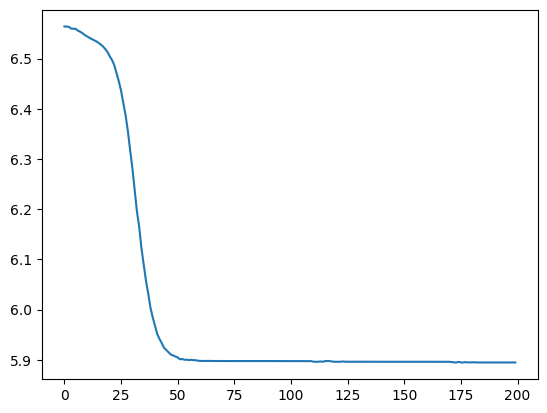

In [ ]:
# Hyperparameters
learning_rate = 1e-3
num_epochs = 200

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = train_network(model=model, optimizer=optimizer, criterion=criterion, X_train=X_train, y_train=y_train, num_epochs=num_epochs)
plt.plot(range(len(train_loss)), train_loss)
plt.show()

In [ ]:
for pred, true in zip(model(X_train), y_train):
    print(torch.argmax(pred), true)

tensor(321) tensor(0)
tensor(9) tensor(1)
tensor(2) tensor(2)
tensor(479) tensor(3)
tensor(4) tensor(4)
tensor(326) tensor(5)
tensor(327) tensor(6)
tensor(326) tensor(7)
tensor(4) tensor(8)
tensor(9) tensor(9)
tensor(10) tensor(10)
tensor(614) tensor(11)
tensor(12) tensor(12)
tensor(69) tensor(13)
tensor(14) tensor(14)
tensor(15) tensor(15)
tensor(16) tensor(16)
tensor(17) tensor(17)
tensor(18) tensor(18)
tensor(319) tensor(19)
tensor(20) tensor(20)
tensor(237) tensor(21)
tensor(22) tensor(22)
tensor(23) tensor(23)
tensor(24) tensor(24)
tensor(25) tensor(25)
tensor(26) tensor(26)
tensor(27) tensor(27)
tensor(158) tensor(28)
tensor(29) tensor(29)
tensor(499) tensor(30)
tensor(31) tensor(31)
tensor(32) tensor(32)
tensor(33) tensor(33)
tensor(34) tensor(34)
tensor(35) tensor(35)
tensor(36) tensor(36)
tensor(477) tensor(37)
tensor(38) tensor(38)
tensor(39) tensor(39)
tensor(40) tensor(40)
tensor(41) tensor(41)
tensor(488) tensor(42)
tensor(14) tensor(43)
tensor(44) tensor(44)
tensor(45) te

In [ ]:
query = input()
# vectorized_query = doc2vec_model.infer_vector(word_tokenize(query))
# vectorized_query
# output = model(torch.FloatTensor(vectorized_query.reshape(1, -1)))
output = model(torch.FloatTensor(
        vectorizer.transform([query]).toarray()
    ))
pred_func = label_map[torch.argmax(output).item()]

print(f'Try {pred_func}!')
print(f'https://numpy.org/doc/stable/reference/generated/{pred_func}.html')


Try numpy.ma.MaskedArray.resize!
https://numpy.org/doc/stable/reference/generated/numpy.ma.MaskedArray.resize.html


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

## Clustering

In [112]:
from sklearn.cluster import KMeans
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tokenized = [word_tokenize(t) for t in df['text']]
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized)]

doc2vec_model = Doc2Vec(tagged_data, vector_size=14)

X_train = torch.FloatTensor([doc2vec_model.infer_vector(t) for t in tokenized])
kmeans = KMeans(n_clusters=200, random_state=0).fit(X_train)
indices = [i for i, x in enumerate(kmeans.labels_) if x == kmeans.labels_[reverse_label_map['numpy.hstack']]]
print([f'{i}: label_map[i]' for i in indices], '\n', f"cluster: {kmeans.labels_[reverse_label_map['numpy.hstack']]}")

[nltk_data] Downloading package punkt to /Users/arymehr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['76: label_map[i]', '379: label_map[i]'] 
 cluster: 143


In [125]:
kmeans.predict(torch.FloatTensor(doc2vec_model.infer_vector([input('query: ')]).reshape(1, -1)))

array([92], dtype=int32)